<a href="https://colab.research.google.com/github/willcoomans5/mlb_predictions/blob/main/mlb_game_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# import os, sys
# nb_path = '/content/notebooks'
# os.symlink('/content/drive/MyDrive/Colab Notebooks', nb_path)
# sys.path.insert(0,nb_path)

In [ ]:
!pip3 install torch torchvision ray torchaudio pybaseball scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 426.1/426.1 kB 21.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manyli

In [ ]:
import os
import sys
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import *
import numpy as np
import pybaseball as pyb

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from datetime import date
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import train_test_split



pyb.cache.enable()
pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)


In [ ]:
path = '/content/drive/MyDrive/mlbpredictions/'

In [ ]:
statcast_data = pyb.statcast(start_dt='2023-03-28', end_dt='2023-11-01')

This is a large query, it may take a moment to complete


100%|██████████| 219/219 [05:54<00:00,  1.62s/it]


In [ ]:
print(statcast_data.shape)
statcast_data.to_csv(path + "statcast_2023.csv")

NameError: name 'statcast_data' is not defined

In [ ]:
# Interesting Features:
# use release_spin_rate, spin_axis, vx0, vy0, vz0, pfx_x, pfx_z
# maybe release_extension, release_pos_x, release_pos_z

In [427]:
sc = pd.read_csv(path + "statcast_2023.csv")
data = sc.sample(200000, random_state=42)

In [428]:
features = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'p_throws', 'balls', 'strikes']

target = 'pitch_name'
data = data[features + [target]]
X = data.drop(columns=["pitch_name"])
y = data["pitch_name"]

train_valid, test = train_test_split(data, test_size=0.2, random_state=42)
train, valid = train_test_split(train_valid, test_size=0.2, random_state=42)
print(train.shape)
print(valid.shape)
print(test.shape)

(128000, 15)
(32000, 15)
(40000, 15)


In [360]:
print(train["pitch_name"].value_counts())
print("\n")
print(train.isnull().sum())

pitch_name
4-Seam Fastball    41336
Slider             21513
Changeup           13786
Name: count, dtype: int64


release_spin_rate    390
release_speed          1
release_extension     90
release_pos_x          1
release_pos_z          1
spin_axis            391
vx0                    1
vy0                    1
vz0                    1
pfx_x                  1
pfx_z                  1
p_throws               0
balls                  0
strikes                0
pitch_name             0
dtype: int64


Only 103 out of our 128000 training samples have missing dependent values. As shown above, these data points appear to be insignificant, as most of the remaining features have missing values as well. Consequently, removing these 103 rows is justified.

Below, we will handle the rest of the missing values appropriately. We will also one hot encode our "p_throws" column.



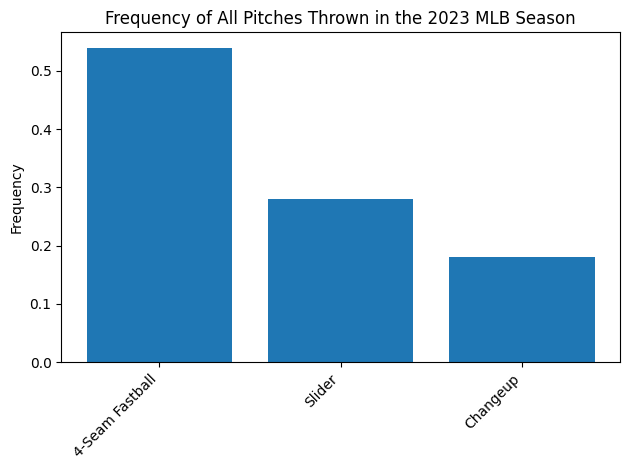

In [361]:
def remove_target_null(data):
  data = data[~data["pitch_name"].isnull()]
  return data

train = remove_target_null(train)

freq = train["pitch_name"].value_counts() / len(train)
plt.bar(x=freq.index, height=freq)
plt.xticks(rotation=45, ha='right')
plt.title("Frequency of All Pitches Thrown in the 2023 MLB Season")
plt.ylabel("Frequency")
plt.tight_layout()

In [362]:
# Map right handed pitchers to the value 1 and left handed pitchers to the value 0

def p_throws_ohe(data):
  mapping_dict = {"L": 0, "R": 1}

  # Check for existing numerical values and map only non-numerical values
  if type(data['p_throws'].iloc[0]) == str:
    data['p_throws'] = train['p_throws'].map(mapping_dict)
  return data


# Display the result
train = p_throws_ohe(train)
train.head()

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
345135,2209.0,98.8,6.5,-1.62,5.84,206.0,4.926560,-143.693296,-5.942054,-0.57,1.47,1,0,0,4-Seam Fastball
433431,2653.0,83.6,7.8,-2.14,5.34,274.0,6.284207,-121.652556,-2.142796,-1.43,0.05,1,0,0,Changeup
624595,2414.0,96.9,6.4,-2.75,5.50,208.0,9.834019,-140.680400,-7.153856,-0.60,1.63,1,1,1,4-Seam Fastball
187119,2029.0,94.4,5.7,-2.02,5.79,219.0,8.124374,-137.185937,-5.212608,-0.77,1.04,1,1,1,4-Seam Fastball
398724,1868.0,85.8,6.2,2.10,4.84,82.0,-5.603282,-124.857862,1.803321,1.47,0.02,0,3,1,Changeup


Let's visualize some of the distributions of our features

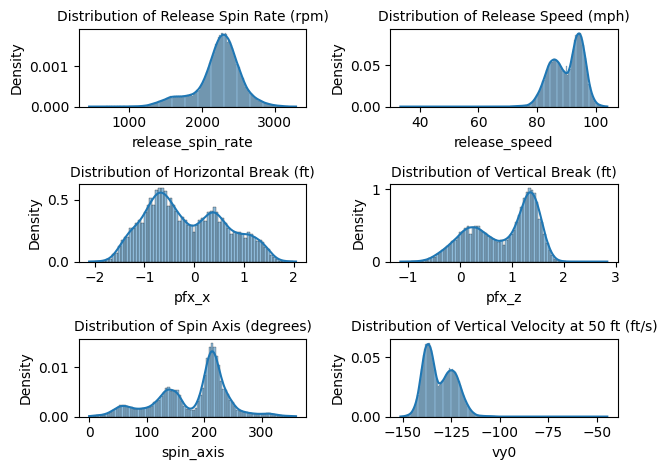

In [363]:
fig, ax = plt.subplots(3, 2)

sns.histplot(data=train, x="release_spin_rate", stat='density', kde=True, ax=ax[0, 0])
ax[0, 0].set_title("Distribution of Release Spin Rate (rpm)", fontsize=10)

sns.histplot(data=train, x="release_speed", stat='density', kde=True, ax=ax[0, 1])
ax[0, 1].set_title("Distribution of Release Speed (mph)", fontsize=10)

sns.histplot(data=train, x="pfx_x", stat='density', kde=True, ax=ax[1, 0])
ax[1, 0].set_title("Distribution of Horizontal Break (ft)", fontsize=10)

sns.histplot(data=train, x="pfx_z", stat='density', kde=True, ax=ax[1, 1])
ax[1, 1].set_title("Distribution of Vertical Break (ft)", fontsize=10)

sns.histplot(data=train, x="spin_axis", stat='density', kde=True, ax=ax[2, 0])
ax[2, 0].set_title("Distribution of Spin Axis (degrees)", fontsize=10)

sns.histplot(data=train, x="vy0", stat='density', kde=True, ax=ax[2, 1])
ax[2, 1].set_title("Distribution of Vertical Velocity at 50 ft (ft/s)", fontsize=10)


plt.tight_layout()
plt.show()

In [364]:
def fill_vals(data):
  data['release_spin_rate'] = data['release_spin_rate'].fillna(data['release_spin_rate'].mean())
  data['release_speed'] = data['release_speed'].fillna(data['release_speed'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_extension'] = data['release_extension'].fillna(data['release_extension'].mean())
  data['release_pos_x'] = data['release_pos_x'].fillna(data['release_pos_x'].mode()[0])
  data['release_pos_z'] = data['release_pos_z'].fillna(data['release_pos_z'].mean())
  data['spin_axis'] = data['spin_axis'].fillna(data['spin_axis'].mode()[0])
  data['pfx_x'] = data['pfx_x'].fillna(data['pfx_x'].mean())
  data['pfx_z'] = data['pfx_z'].fillna(data['pfx_z'].mean())
  data['vx0'] = data['vx0'].fillna(data['vx0'].mean())
  data['vy0'] = data['vy0'].fillna(data['vy0'].mean())
  data['vz0'] = data['vz0'].fillna(data['vz0'].mean())
  return data

train = fill_vals(train)
print(train.isnull().sum())

release_spin_rate    0
release_speed        0
release_extension    0
release_pos_x        0
release_pos_z        0
spin_axis            0
vx0                  0
vy0                  0
vz0                  0
pfx_x                0
pfx_z                0
p_throws             0
balls                0
strikes              0
pitch_name           0
dtype: int64


In [365]:
def label_encode(data):
  le = LabelEncoder()
  le.fit(data['pitch_name'])
  data['pitch_name'] = le.transform(data['pitch_name'])
  return data, le

train, le = label_encode(train)
for idx, label in enumerate(le.classes_):
  print(f"label: {label}, encoding: {idx}")

label: 4-Seam Fastball, encoding: 0
label: Changeup, encoding: 1
label: Slider, encoding: 2


In [366]:
def normalize(data):
  cols = ['release_spin_rate', 'release_speed', 'release_extension',
            'release_pos_x', 'release_pos_z', 'spin_axis', 'vx0', 'vy0',
            'vz0', 'pfx_x', 'pfx_z', 'balls', 'strikes']

  df = data.copy()[cols]
  data.loc[:, cols] = (df - df.min()) / (df.max() - df.min())
  return data

train = normalize(train)
train

,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes,pitch_name
345135,0.618947,0.927660,0.555556,0.325557,0.757208,0.572222,0.580088,0.070464,0.368857,0.370192,0.656642,1,0.000000,0.0,0
433431,0.774737,0.712057,0.844444,0.270414,0.681335,0.761111,0.614518,0.277042,0.485255,0.163462,0.300752,1,0.000000,0.0,1
624595,0.690877,0.900709,0.533333,0.205726,0.705615,0.577778,0.704543,0.098702,0.331731,0.362981,0.696742,1,0.333333,0.5,0
187119,0.555789,0.865248,0.377778,0.283139,0.749621,0.608333,0.661186,0.131454,0.391205,0.322115,0.548872,1,0.333333,0.5,0
398724,0.499298,0.743262,0.488889,0.720042,0.605463,0.227778,0.313046,0.247000,0.606152,0.860577,0.293233,0,1.000000,0.5,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372991,0.549825,0.758865,0.666667,0.156946,0.681335,0.661111,0.628351,0.232909,0.547387,0.189904,0.353383,1,0.000000,0.5,1
175735,0.583509,0.771631,0.688889,0.335101,0.640364,0.425000,0.563148,0.218500,0.440351,0.620192,0.360902,1,0.000000,0.5,2
512359,0.573333,0.817021,0.488889,0.378579,0.864947,0.580556,0.549887,0.176060,0.341629,0.399038,0.598997,1,0.666667,0.5,0
244001,0.844912,0.787234,0.488889,0.457052,0.778452,0.302778,0.476041,0.202629,0.459281,0.661058,0.245614,1,0.333333,0.0,2


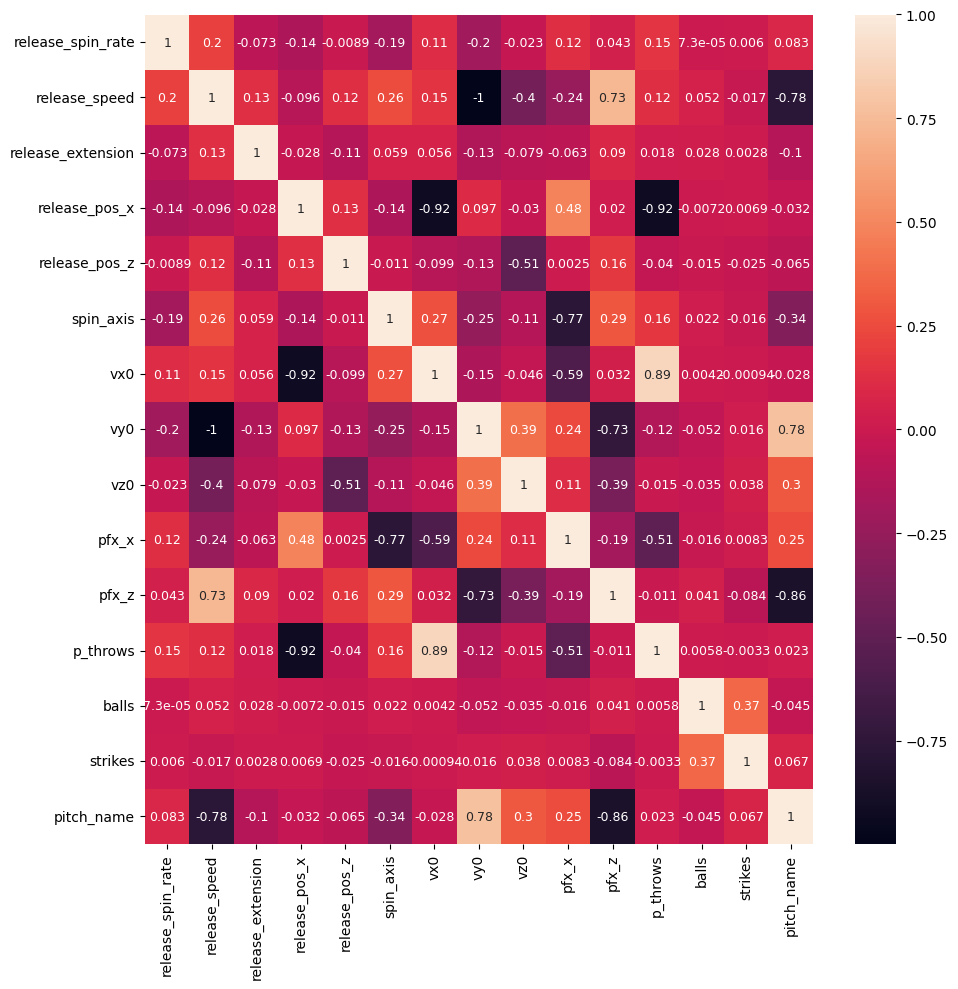

In [367]:
corr_data = train[features + [target]].corr(method='pearson')
plt.figure(figsize=(10, 10))
sns.heatmap(data=corr_data, annot=True, annot_kws={"size": 9})
plt.tight_layout()

In [425]:
def pipeline(data):
  df = data.copy()
  df = remove_target_null(df)
  df = df.pipe(p_throws_ohe)
  df = df.pipe(fill_vals)
  df = label_encode(df)[0]
  df = normalize(df)
  y = torch.tensor(df["pitch_name"].values, dtype=torch.long)
  X = torch.tensor(df.drop(columns=["pitch_name"]).values, dtype=torch.float32)
  # return X, y
  return df.drop(columns=["pitch_name"]), df["pitch_name"]

X_train, Y_train = pipeline(train)
X_valid, Y_valid = pipeline(valid)
X_test, Y_test = pipeline(test)


,release_spin_rate,release_speed,release_extension,release_pos_x,release_pos_z,spin_axis,vx0,vy0,vz0,pfx_x,pfx_z,p_throws,balls,strikes
265833,0.665010,0.781538,0.189189,0.232583,0.675039,0.658333,0.654323,0.215870,0.421001,0.257426,0.658307,NaN,0.666667,1.0
12250,0.578585,0.633846,0.405405,0.747053,0.725275,0.397222,0.238331,0.364837,0.496126,0.668317,0.771160,NaN,0.000000,0.5
239380,0.574379,0.596923,0.540541,0.719185,0.817896,0.419444,0.371779,0.399867,0.400097,0.460396,0.426332,NaN,0.000000,0.5
6262,0.692543,0.424615,0.405405,0.350482,0.882261,0.675000,0.583910,0.576789,0.321202,0.497525,0.376176,NaN,0.333333,1.0
471599,0.658126,0.747692,0.567568,0.369775,0.832025,0.550000,0.632473,0.248341,0.278022,0.507426,0.658307,NaN,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
490304,0.546845,0.704615,0.324324,0.186495,0.697017,0.613889,0.734587,0.294502,0.708780,0.321782,0.730408,NaN,0.000000,0.5
333908,0.696750,0.476923,0.594595,0.214362,0.527473,0.358333,0.710775,0.520578,0.567525,0.596535,0.432602,NaN,0.000000,1.0
470407,0.534608,0.507692,0.513514,0.280815,0.714286,0.525000,0.726404,0.491921,0.394303,0.524752,0.498433,NaN,0.000000,0.0
131584,0.615679,0.732308,0.378378,0.408360,0.706436,0.633333,0.610896,0.265147,0.363893,0.215347,0.761755,NaN,1.000000,0.5


In [369]:
class CustomMLBDataSet(Dataset):
  def __init__(self, features, targets):
    self.features = features
    self.targets = targets

  def __len__(self):
    return len(self.features)

  def __getitem__(self, idx):
    sample = self.features[idx], self.targets[idx]
    return sample

train_dataset = CustomMLBDataSet(X_train, Y_train)
valid_dataset = CustomMLBDataSet(X_valid, Y_valid)
test_dataset = CustomMLBDataSet(X_test, Y_test)

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

In [370]:
train_features, train_labels = next(iter(train_dataloader))
print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')

Feature batch shape: torch.Size([64, 14])
Labels batch shape: torch.Size([64])


In [401]:
class SoftmaxRegression(nn.Module):
  def __init__(self):
    super().__init__()
    self.linear = nn.Linear(14, 17, bias=True)

  def forward(self, x):
    logits = self.linear(x)
    return logits

  def pred_labels(self, logits):
    probs = nn.Softmax(dim=1)(logits)
    return torch.argmax(probs, dim=1)


  def train_model(self, dataloader, epochs, lr):
    optimizer = optim.SGD(self.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    self.train()

    for epoch in range(epochs):
      print(f'EPOCH: {epoch + 1}\n=============')
      running_loss = 0
      for idx, data in enumerate(train_dataloader):
        features, labels = data

        # Each "features" has 64 samples, a tensor with dimensions (16, 14)
        # Each "labels" has 64 samples with, a tensor with dimensions(16, 1)
        features = features.to(device)
        labels = labels.to(device)

        # Feedforward the features to get our predictions from the neural network.
        logits = self.forward(features)

        # Reset the gradients to zero since gradients accumulate with each call to backward()
        optimizer.zero_grad()

        # Compute the Cross Entropy Loss between our predictions and our true labels.
        # nn.CrossEntropyLoss() internally applies nn.LogSoftmax() and nn.NLLLoss()
        loss = loss_fn(logits, labels)

        # Compute the gradient of the loss function (cross-entropy) with respect to each parameter
        loss.backward()

        # Update the parameters with stochastic gradient descent
        optimizer.step()

        running_loss += loss.item()
        if idx % 100 == 99:
          print(f'Batch Number: {idx + 1}')
          print(f'Running Loss: {running_loss / 2000}\n')
          running_loss = 0

  def test_accuracy(self, dataloader, loss_fn):
    total_loss = 0
    correct = 0
    num_batches = len(dataloader)
    num_rows = len(dataloader.dataset)
    self.eval()

    with torch.no_grad():
      for i, data in enumerate(dataloader):
        features, labels = data
        features = features.to(device)
        labels = labels.to(device)

        logits = self.forward(features)
        preds = self.pred_labels(logits)

        total_loss += loss_fn(logits, labels).item()
        correct += torch.sum(preds == labels).item()

        print(total_loss)

    print(f'Average Loss: {total_loss / num_batches}')
    print(f'Accuracy: {100 * correct / num_rows}')




In [402]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    print(f'GPU device name: {torch.cuda.get_device_name(device)}')
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device('cpu')

model = SoftmaxRegression().to(device)
print(model)

No GPU available, using the CPU instead.
SoftmaxRegression(
  (linear): Linear(in_features=14, out_features=17, bias=True)
)


In [403]:
ex_data = torch.rand(2, 14, device=device)


logits = model(ex_data)
print(logits)

# performs softmax along the columns, i.e. the sum of the columns is 1
proba = nn.Softmax(dim=1)(logits)
print(proba)


print(torch.argmax(proba, dim=1))

tensor([[-0.1613,  0.2984,  0.3024, -0.4449,  0.1010,  0.0467, -0.2835, -0.6774,
         -0.3523, -0.1411,  0.1949,  0.0901,  0.2617,  0.2424, -0.3793,  0.1415,
          0.0520],
        [ 0.0754,  0.3197,  0.4452, -0.5418,  0.1036,  0.1780, -0.4238, -0.6453,
         -0.2818, -0.2269,  0.3366,  0.1326,  0.3672,  0.0990, -0.5030, -0.2075,
         -0.0538]], grad_fn=<AddmmBackward0>)
tensor([[0.0502, 0.0795, 0.0798, 0.0378, 0.0653, 0.0618, 0.0444, 0.0300, 0.0415,
         0.0512, 0.0717, 0.0646, 0.0766, 0.0752, 0.0404, 0.0680, 0.0621],
        [0.0631, 0.0806, 0.0913, 0.0340, 0.0649, 0.0699, 0.0383, 0.0307, 0.0442,
         0.0466, 0.0819, 0.0668, 0.0845, 0.0646, 0.0354, 0.0476, 0.0555]],
       grad_fn=<SoftmaxBackward0>)
tensor([2, 2])


In [404]:
epochs = 5
lr = 0.01

model.train_model(train_dataloader, epochs, lr)

EPOCH: 1
Batch Number: 100
Running Loss: 0.10582739913463593

Batch Number: 200
Running Loss: 0.0725171839594841

Batch Number: 300
Running Loss: 0.06338682442903519

Batch Number: 400
Running Loss: 0.05764849877357483

Batch Number: 500
Running Loss: 0.05581231823563576

Batch Number: 600
Running Loss: 0.05345405513048172

Batch Number: 700
Running Loss: 0.051715555608272554

Batch Number: 800
Running Loss: 0.05004880538582802

Batch Number: 900
Running Loss: 0.049478092819452285

Batch Number: 1000
Running Loss: 0.048415079206228256

Batch Number: 1100
Running Loss: 0.047620162159204484

EPOCH: 2
Batch Number: 100
Running Loss: 0.04576482555270195

Batch Number: 200
Running Loss: 0.04561205106973648

Batch Number: 300
Running Loss: 0.04447148695588112

Batch Number: 400
Running Loss: 0.044120452493429184

Batch Number: 500
Running Loss: 0.044036971211433414

Batch Number: 600
Running Loss: 0.043501472115516665

Batch Number: 700
Running Loss: 0.04200271585583687

Batch Number: 800
Ru

In [417]:
total_loss = 0

data = iter(valid_dataloader)

total_loss = 0

features, labels = next(data)
logits = model.forward(features)
preds = model.pred_labels(logits)

loss = loss_fn(logits, labels)
print(loss)
features


tensor(nan, grad_fn=<NllLossBackward0>)


tensor([[0.3755, 0.5477, 0.4324, 0.2304, 0.6986, 0.7306, 0.7454, 0.4497, 0.4585,
         0.1856, 0.3323,    nan, 0.0000, 0.0000],
        [0.6474, 0.8738, 0.5676, 0.4630, 0.9042, 0.5333, 0.5468, 0.1234, 0.2262,
         0.4950, 0.7398,    nan, 0.0000, 1.0000],
        [0.7101, 0.8062, 0.5946, 0.6795, 0.8305, 0.4556, 0.4018, 0.1912, 0.3008,
         0.5074, 0.7868,    nan, 0.0000, 1.0000],
        [0.6497, 0.5908, 0.4054, 0.2508, 0.6703, 0.3250, 0.6311, 0.4019, 0.6416,
         0.5421, 0.4169,    nan, 0.0000, 0.0000],
        [0.7828, 0.6523, 0.3784, 0.4051, 0.7221, 0.5139, 0.6362, 0.3390, 0.4635,
         0.5569, 0.5361,    nan, 0.3333, 0.5000],
        [0.6608, 0.5046, 0.5135, 0.3773, 0.7708, 0.3472, 0.6274, 0.4880, 0.5239,
         0.5223, 0.3918,    nan, 0.6667, 1.0000],
        [0.5610, 0.6308, 0.4054, 0.2015, 0.8242, 0.5917, 0.7831, 0.3717, 0.3668,
         0.3243, 0.7335,    nan, 0.3333, 0.5000],
        [0.6662, 0.4062, 0.5946, 0.1779, 0.7017, 0.1111, 0.7102, 0.5918, 0.4499,
  

In [407]:
model.test_accuracy(valid_dataloader, nn.CrossEntropyLoss())

# features, labels = next(iter(train_dataloader))
# logits = model(features)
# pred_labels = model.pred_labels(logits)

# print(pred_labels)
# print(labels)

# print(torch.sum(pred_labels==labels))

nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan
nan


In [179]:
# Example of target with class indices
loss = nn.CrossEntropyLoss()
input = torch.randn(3, 5, requires_grad=True)
target = torch.empty(3, dtype=torch.long).random_(5)
output = loss(input, target)
output.backward()
# Example of target with class probabilities
input = torch.randn(3, 5, requires_grad=True)
target = torch.randn(3, 5).softmax(dim=1)
output = loss(input, target)
output.backward()

output

tensor(2.0180, grad_fn=<DivBackward1>)

In [ ]:


import torch.nn.functional as F

# Sample logits (batch size = 2, number of classes = 3)
logits = torch.tensor([[1.0, 2.0, 3.0],
                       [1.0, 2.0, 3.0]])
# Sample target labels
targets = torch.tensor([2, 0])

# Create the loss function
criterion = nn.CrossEntropyLoss()


# Compute the loss
print(-(1 * np.log(0.6652) + 1 * np.log(0.0900)))

sum_loss = F.cross_entropy(logits, targets, reduction='sum')
avg_loss = F.cross_entropy(logits, targets, reduction='mean')
indiv_loss = F.cross_entropy(logits, targets, reduction='none')

print(sum_loss)
print(avg_loss)
print(indiv_loss)